---
# TD2 Clustering par la méthode k-means
## - Application à la gestion des risques -
---

### Objectif pédagogique

À l'issue de ce TD, l'étudiant devra être capable de :

- Comprendre le principe mathématique de l'algorithme k-means ;
- Implémenter et utiliser k-means en Python avec *`scikit-learn`* ;
- Choisir un nombre pertinent de clusters (méthode du coude, silhouette) ;
- Interpréter des clusters dans un contexte de gestion des risques ;
- Discuter les limites de k-means pour des applications réelles de gestion du risque.

### Contexte applicatif : gestion des risques naturels – incendies de forêt et WUI

On se place dans le contexte de la gestion des risques naturels, et plus particulièrement des incendies de forêt à l’interface forêt–habitat (Wildland–Urban Interface, WUI).

Les territoires WUI sont caractérisés par une forte hétérogénéité des conditions de risque, liée à la végétation, à la topographie, au climat et à l’exposition des enjeux humains et matériels.

L’objectif est d’utiliser un algorithme de clustering non supervisé (k-means) pour :

- Identifier des profils homogènes de zones WUI ;
- Mettre en évidence des niveaux de risque différenciés ;
- Aider à la priorisation des actions de prévention (débroussaillement, urbanisme, moyens de lutte).
---

### Partie 1 : Génération d'un jeu de données de risque incendie (WUI)

On considère un territoire découpé en 300 zones WUI, caractérisées par les indicateurs suivants :

*`fuel_load`* : charge combustible (kg/m²) ;

*`slope`* : pente moyenne du terrain (°) ;

*`wind_exposure`* : exposition moyenne au vent (m/s) ;

*`ignition_freq`* : fréquence annuelle d’ignitions ;

*`asset_value`* : valeur des enjeux exposés (M€).

Ces variables sont inspirées des modèles physiques et empiriques utilisés en science du feu et en analyse de vulnérabilité territoriale.

#### 1.1 Simulation des données

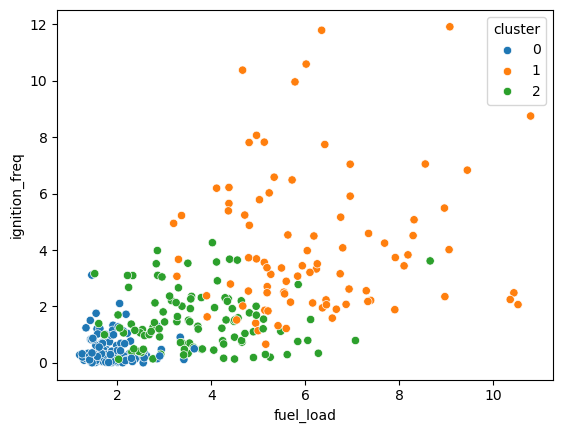

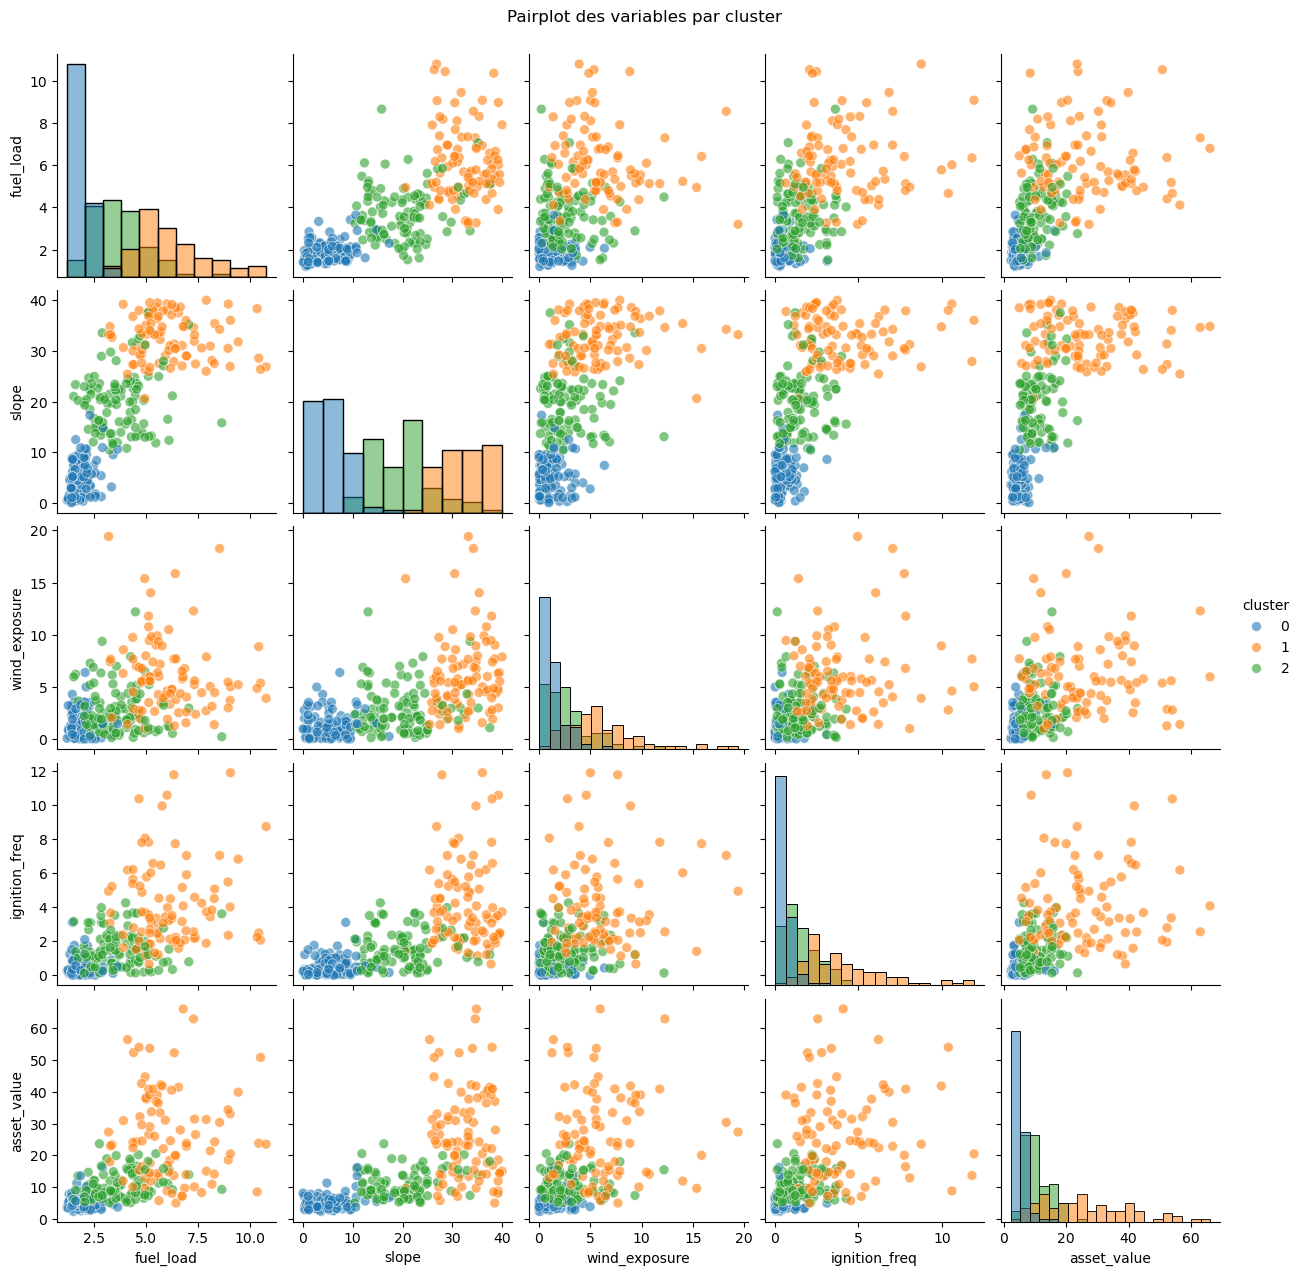

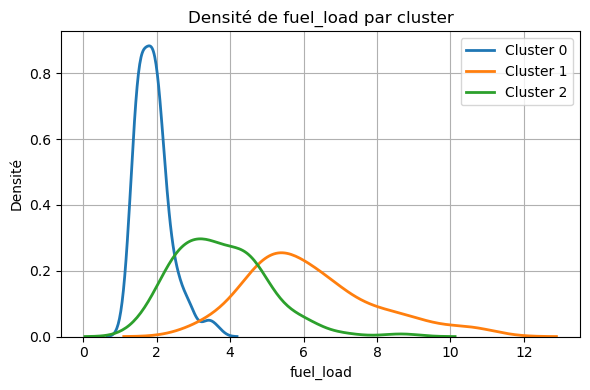

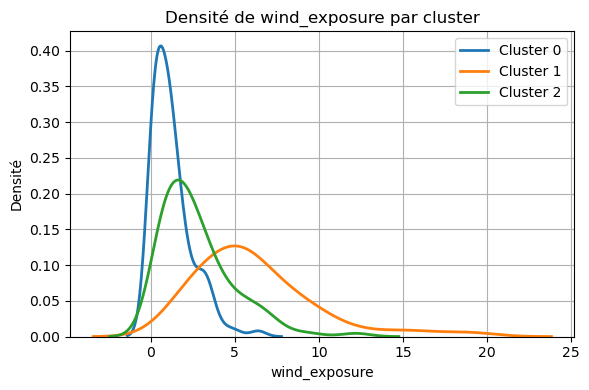

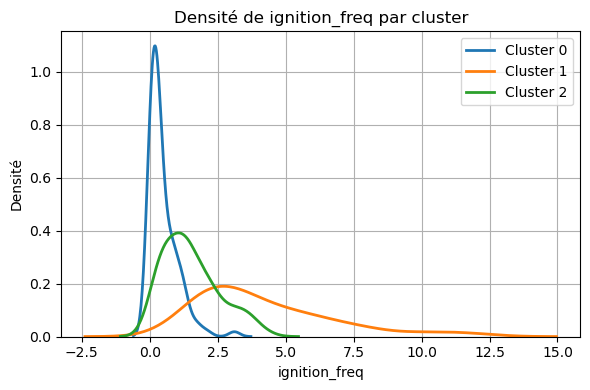

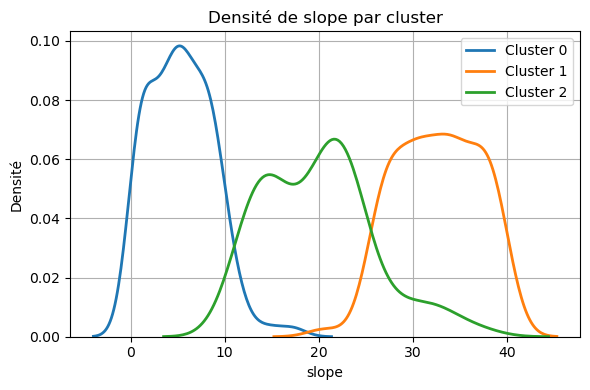

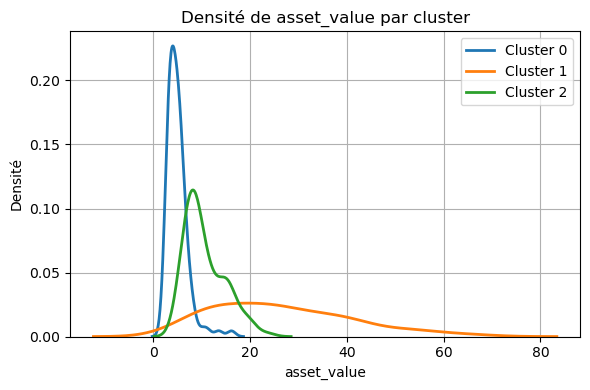

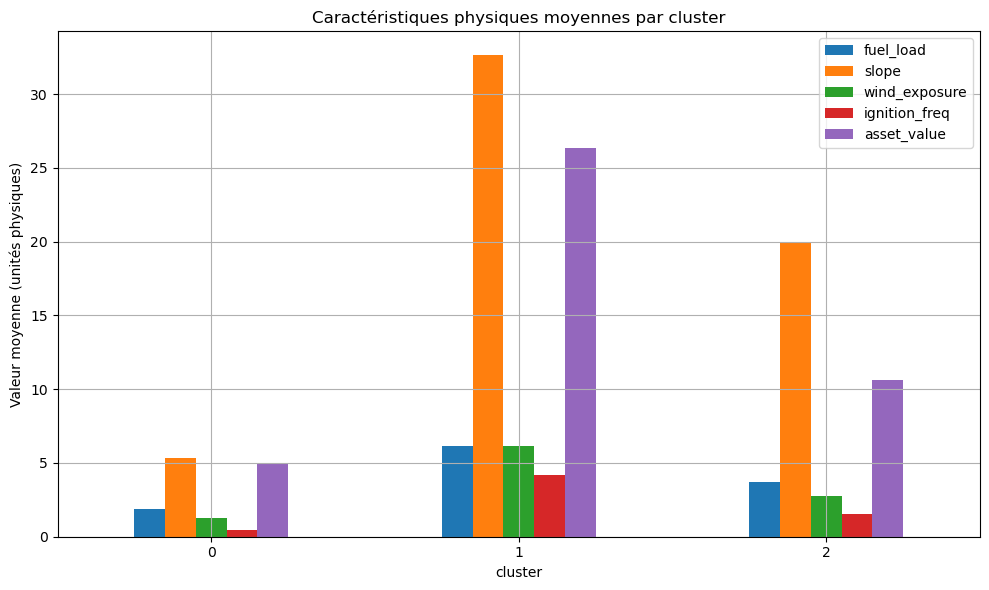

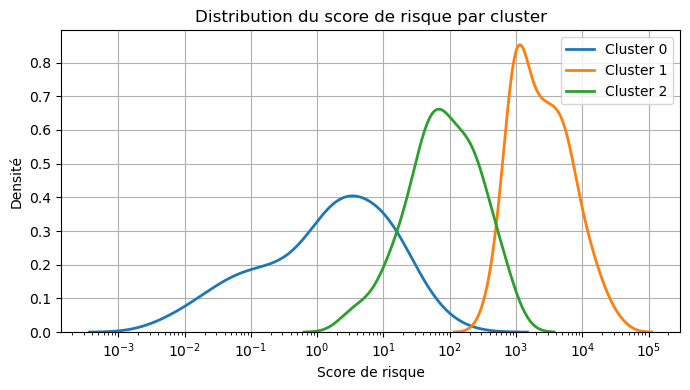

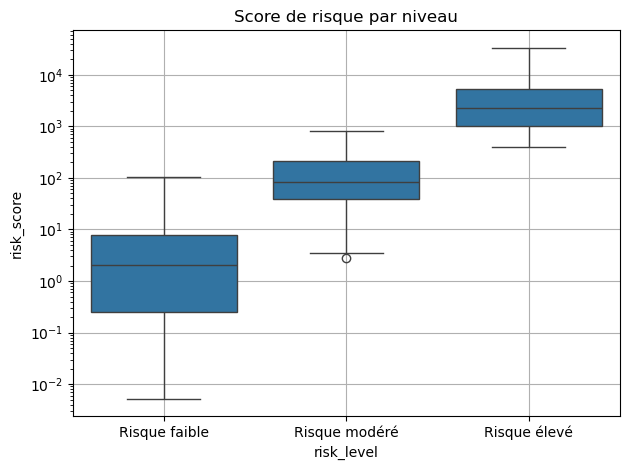

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pandas.plotting import scatter_matrix

import seaborn as sns

import statsmodels.api as sm

#--------------------------------------------------------------------------------------------------------------------------
# Data generation
#--------------------------------------------------------------------------------------------------------------------------

n = 300

cluster_sizes = [100, 100, 100]

data_list = []

# Cluster 0 : risque faible
data_list.append(pd.DataFrame({
    "fuel_load": np.random.lognormal(mean=0.6, sigma=0.2, size=cluster_sizes[0]),
    "slope": np.random.uniform(0, 10, size=cluster_sizes[0]),
    "wind_exposure": np.random.gamma(1.0, 1.0, size=cluster_sizes[0]),
    "ignition_freq": np.random.gamma(1.0, 0.5, size=cluster_sizes[0]),
    "asset_value": np.random.lognormal(mean=1.5, sigma=0.3, size=cluster_sizes[0]),
}))

# Cluster 1 : risque modéré
data_list.append(pd.DataFrame({
    "fuel_load": np.random.lognormal(mean=1.2, sigma=0.3, size=cluster_sizes[1]),
    "slope": np.random.uniform(10, 25, size=cluster_sizes[1]),
    "wind_exposure": np.random.gamma(2.0, 1.5, size=cluster_sizes[1]),
    "ignition_freq": np.random.gamma(1.5, 1.0, size=cluster_sizes[1]),
    "asset_value": np.random.lognormal(mean=2.2, sigma=0.4, size=cluster_sizes[1]),
}))

# Cluster 2 : risque élevé
data_list.append(pd.DataFrame({
    "fuel_load": np.random.lognormal(mean=1.8, sigma=0.3, size=cluster_sizes[2]),
    "slope": np.random.uniform(25, 40, size=cluster_sizes[2]),
    "wind_exposure": np.random.gamma(3.0, 2.0, size=cluster_sizes[2]),
    "ignition_freq": np.random.gamma(2.5, 1.5, size=cluster_sizes[2]),
    "asset_value": np.random.lognormal(mean=3.0, sigma=0.6, size=cluster_sizes[2]),
}))

data = pd.concat(data_list, ignore_index=True)


#--------------------------------------------------------------------------------------------------------------------------
# standardisation
#--------------------------------------------------------------------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

#--------------------------------------------------------------------------------------------------------------------------
# entrainement du modele
#--------------------------------------------------------------------------------------------------------------------------

k = 3
kmeans = KMeans(n_clusters=k, n_init=10000, random_state=42)
labels = kmeans.fit_predict(X_scaled)


# ajoute une colonne cluster au DataFrame avec le numero de cluster auquel chaque observation (ligne) appartient
data['cluster'] = labels

#--------------------------------------------------------------------------------------------------------------------------
# statistique par cluster
#--------------------------------------------------------------------------------------------------------------------------

# Le DataFrame data est partitionné selon la valeur de la colonne cluster
# On obtient 3 groupes correspondant aux 3 clusters
# Pour chaque groupe, on calcule la moyenne de chaque variable
# on obtient un nouveau DataFrame cluster_summary avec 3 ligne correspondant aux 3 cluster et chaque colonne correspond aux moyennes des variables
# on est dans l'espace physique
cluster_summary = data.groupby('cluster').mean()
# affiche le contenu de la variable
cluster_summary

#--------------------------------------------------------------------------------------------------------------------------
# visualisation
#--------------------------------------------------------------------------------------------------------------------------

# Scatterplot fuel_load vs ignition_freq coloré par cluster
sns.scatterplot(
data=data,
x="fuel_load",
y="ignition_freq",
hue="cluster",
palette="tab10"
)

# Pairplot de toutes les variables avec les clusters
sns.pairplot(
    data,
    vars=["fuel_load", "slope", "wind_exposure", "ignition_freq", "asset_value"],
    hue="cluster",                # couleur par cluster
    palette="tab10",               # palette de couleurs
    diag_kind="hist",              # histogrammes sur la diagonale
    plot_kws={"alpha":0.6, "s":50}  # transparence et taille des points
)
plt.suptitle("Pairplot des variables par cluster", y=1.02)
plt.show()

# Densité de chaque variable par cluster (KDE Kernel Density Estimate)
variables = ["fuel_load", "wind_exposure", "ignition_freq", "slope", "asset_value"]

for var in variables:
    plt.figure(figsize=(6,4))
    
    for c in sorted(data["cluster"].unique()):
        sns.kdeplot(
            data=data[data["cluster"] == c],
            x=var,
            label=f"Cluster {c}",
            fill=False,
            linewidth=2
        )
    
    plt.title(f"Densité de {var} par cluster")
    plt.xlabel(var)
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#histogrammes par cluster des moyennes des variables
cluster_summary.plot(kind="bar", figsize=(10,6))
plt.ylabel("Valeur moyenne (unités physiques)")
plt.title("Caractéristiques physiques moyennes par cluster")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcul du score de risque comme le produit des variables contributives
data["risk_score"] = (
    data["fuel_load"] *
    data["wind_exposure"] *
    data["ignition_freq"] *
    data["asset_value"]
)

# Densité du score de risque par cluster
plt.figure(figsize=(7,4))
for c in sorted(data["cluster"].unique()):
    sns.kdeplot(
        data=data[data["cluster"] == c],
        x="risk_score",
        label=f"Cluster {c}",
        linewidth=2,
        log_scale=True
    )

plt.xlabel("Score de risque")
plt.ylabel("Densité")
plt.title("Distribution du score de risque par cluster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Boite a moustaches (boxplot) du score de risque par cluster
risk_by_cluster = data.groupby("cluster")["risk_score"].mean()
risk_order = risk_by_cluster.sort_values().index

mapping = {
    risk_order[0]: "Risque faible",
    risk_order[1]: "Risque modéré",
    risk_order[2]: "Risque élevé"
}

data["risk_level"] = data["cluster"].map(mapping)


sns.boxplot(
    data=data,
    x="risk_level",
    y="risk_score",
    order=["Risque faible", "Risque modéré", "Risque élevé"],
    log_scale=True
)
plt.title("Score de risque par niveau")
plt.grid(True)
plt.tight_layout()
plt.show()


